# 1.Data preprocessing


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential 
from keras.layers import LSTM, Dropout, Dense


In [4]:
data_train = pd.read_csv('training_data.csv') 
data_test = pd.read_csv('test_data.csv')
data_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-28,37.667141,37.998573,37.178570,37.279999,32.658363,129996300
1,2010-07-29,37.244286,37.521427,36.585712,36.872856,32.301701,160951700
2,2010-07-30,36.555714,37.099998,36.414288,36.750000,32.194061,112052500
3,2010-08-02,37.205715,37.512856,37.088570,37.407143,32.769741,107013900
4,2010-08-03,37.287144,37.608570,37.060001,37.418571,32.779743,104413400


In [5]:
data_train = data_train.iloc[:,1:2].values
data_test = data_test.iloc[:,1:2].values 

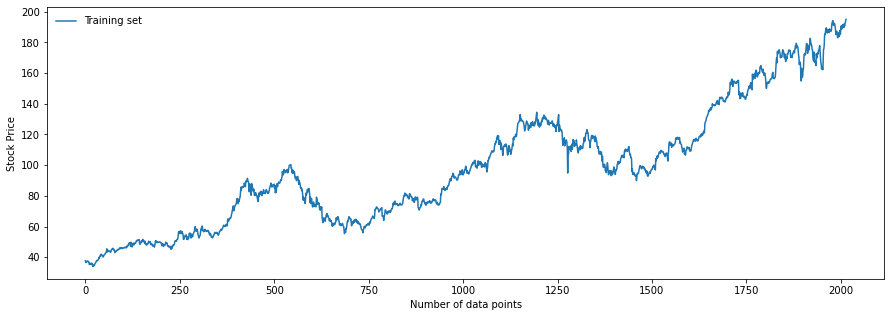

In [6]:
plt.figure(1, figsize = (15,5))
plt.plot(data_train, label = 'Training set')
plt.xlabel('Number of data points')
plt.ylabel('Stock Price')
plt.legend(loc = 'upper left', frameon = False) 

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (-1,1))
data_train_scaled = scaler.fit_transform(data_train)
data_test_scaled = scaler.fit_transform(data_test)

In [8]:
m_train, n_train = data_train.shape
t_step = 60
y_train = list()
x_train = list()

for i in range(t_step,m_train):
    # Create temporary samples
    sample_x_train = data_train_scaled[i-t_step:i]
    sample_y_train = data_train_scaled[i]
    
    # Let's add a padding
    if sample_x_train.shape[0] < t_step:
        var = np.zeros((t_step - sample_x_train.shape[0]),1)
        sample_x_train = np.concatenate((sample_x_train, var), axis = 0)
        sample_y_train = np.concatenate((sample_y_train, var), axis = 0)
    
    # Adding to the lists x_train, y_train
    x_train.append(sample_x_train)
    y_train.append(sample_y_train)
    
x_train = np.array(x_train)
y_train = np.array(y_train)

In [9]:
data_scaled = np.concatenate((data_train_scaled,data_test_scaled))
m, n = data_scaled.shape

m_test, n_test = data_test.shape
x_test = list()
for i in range(m_train, m):
    sample_x_test = data_scaled[i-t_step:i]
    
    # Let's add the padding
    if sample_x_test.shape[0] < t_step:
        var = np.zeros((t_step - sample_x_test.shape[0]),1)
        sample_x_test = np.concatenate((sample_x_test, var), axis = 0)
    
    x_test.append(sample_x_test)
    
# Transform x_test into arrays
x_test = np.array(x_test)
y_test = np.array(scaler.fit_transform(data_test))

# 2.  LSTM model and dropout

In [10]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'tanh', return_sequences = True, batch_size = (None, t_step, 1)))
model.add(Dropout(0.1))
model.add(LSTM(units = 50, activation = 'tanh', return_sequences = False))
model.add(Dropout(0.1))
model.add(Dense(units = 1))

In [11]:
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

In [12]:
n_boot = 10
y_boot = np.zeros((m_test, n_boot))
for i in range(n_boot):
    history = model.fit(x_train, y_train, epochs = 5, batch_size = 32)
    pred = model.predict(x_test)
    pred = np.reshape(pred,(pred.shape[0]))
    y_boot[:,i] = pred

Epoch 1/5
62/62 [==============================] - 6s 97ms/step - loss: 0.0228 - accuracy: 5.1151e-04
Epoch 2/5
62/62 [==============================] - 9s 143ms/step - loss: 0.0034 - accuracy: 5.1151e-04
Epoch 3/5
62/62 [==============================] - 6s 95ms/step - loss: 0.0030 - accuracy: 5.1151e-04
Epoch 4/5
62/62 [==============================] - 7s 105ms/step - loss: 0.0029 - accuracy: 5.1151e-04
Epoch 5/5
62/62 [==============================] - 8s 125ms/step - loss: 0.0029 - accuracy: 5.1151e-04
Epoch 1/5
62/62 [==============================] - 7s 120ms/step - loss: 0.0028 - accuracy: 5.1151e-04
Epoch 2/5
62/62 [==============================] - 7s 107ms/step - loss: 0.0027 - accuracy: 5.1151e-04
Epoch 3/5
62/62 [==============================] - 6s 96ms/step - loss: 0.0024 - accuracy: 5.1151e-04
Epoch 4/5
62/62 [==============================] - 6s 94ms/step - loss: 0.0025 - accuracy: 5.1151e-04
Epoch 5/5
62/62 [==============================] - 6s 102ms/step - loss: 0.00

Text(0, 0.5, 'Loss')

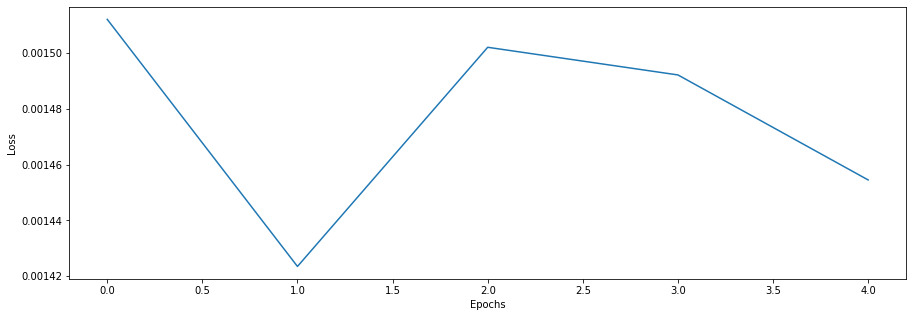

In [13]:
plt.figure(3, figsize = (15,5))
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

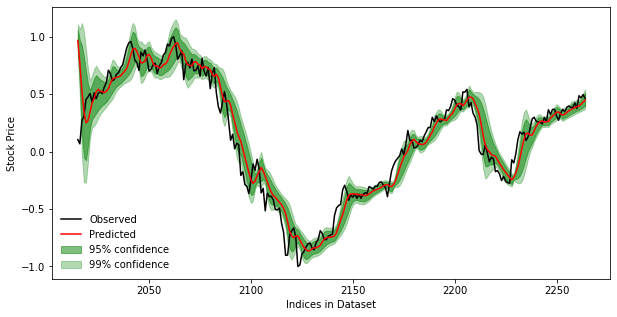

In [21]:
median = np.median(y_boot, axis = 1) 
roll_mean = np.mean(y_boot, axis = 1)
roll_std = np.std(y_boot, axis = 1) 

abs = [i for i in range(m_train,m)]
 
plt.figure(4, figsize= (10,5))
plt.plot(abs, y_test, 'k', label = 'Observed')
plt.plot(abs, median, 'r', label = 'Predicted')
plt.fill_between(abs, roll_mean - 2*roll_std, roll_mean + 2*roll_std, color = 'green', alpha = 0.5, label = '95% confidence')
plt.fill_between(abs, roll_mean - 3*roll_std, roll_mean + 3*roll_std, color = 'green', alpha = 0.3, label = '99% confidence')
plt.xlabel('Indices in Dataset')
plt.ylabel('Stock Price')
plt.legend(loc = 'lower left', frameon = False)
plt.savefig('Comparison_Obs_Pred.png')